#### This notebook implements a complete workflow for hyperspectral image classification using a 1D Convolutional Neural Network (CNN) with PyTorch.

Key stages covered in this code:
**Module Imports and Setup:**  
- Imports standard Python libraries (for file I/O, data handling, timing, plotting) and PyTorch/Sklearn modules (for model building, training, and evaluation).
- The output and checkpoint directories are created, random seeds are set for reproducibility, and the compute device (CPU or GPU) is selected and printed.

**Data Loading:**  
- Loads the normalized hyperspectral image cube, pixel-level label map, and the indices/masks for the training, validation, and test sets from earlier preprocessing steps. 
- These data are essential for preparing PyTorch datasets and loaders.

**Data Preparation:**  
- Prepares data into tensors suitable for input into the CNN, and sets up PyTorch DataLoader objects for mini-batch processing during training/validation/testing.
 
**Model Definition:**  
- Defines a 1D CNN architecture tailored for hyperspectral pixel classification, where each pixel's spectral signature (across many bands) is processed as a 1D sequence.
 
**Training and Evaluation Pipeline:**  
- Implements training loops, validation checks, and testing code to fit the model, track accuracy and loss, and save the best performing models.
- Also includes code for plotting training progress and visualizing results.

The code is cleanly organized for easy modification and reproducible experimentation.






In [1]:
# This cell imports everything and makes the output folders
from pathlib import Path                                                                                                                 # file paths
import time                                                                                                                              # timing
import json                                                                                                                              # read config if needed
import pickle                                                                                                                            # load saved scaler if needed
import numpy as np                                                                                                                       # arrays
import matplotlib.pyplot as plt                                                                                                          # plots

import torch                                                                                                                             # deep learning
import torch.nn as nn                                                                                                                    # layers and losses
import torch.optim as optim                                                                                                              # optimizers
from torch.utils.data import Dataset, DataLoader, TensorDataset                                                                          # data tools

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score, classification_report  # metrics
from sklearn.model_selection import StratifiedKFold                                                                                      # k fold split

np.random.seed(42)                                                                                                                       # seed numpy
torch.manual_seed(42)                                                                                                                    # seed torch

ARTIFACTS = Path("outputs/artifacts_ip")                                                                                                 # artifacts from notebook one
FIGS = Path("outputs/figs")                                                                                                              # figures
RUNS = Path("outputs/runs_cnn1d")                                                                                                        # run logs and checkpoints
FIGS.mkdir(parents=True, exist_ok=True)                                                                                                  # make figs folder
RUNS.mkdir(parents=True, exist_ok=True)                                                                                                  # make runs folder

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                                    # choose device
print("Device", DEVICE)                                                                                                                  # show device

Device cuda


In [2]:
# This cell loads the normalized cube labels and masks prepared earlier
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # normalized cube H W B
labels = np.load(ARTIFACTS / "labels.npy")                  # label map H W with one based ids and zero for background
mask_train = np.load(ARTIFACTS / "mask_train.npy")          # train mask
mask_val = np.load(ARTIFACTS / "mask_val.npy")              # val mask
mask_test = np.load(ARTIFACTS / "mask_test.npy")            # test mask

H, W, B = cube.shape                                        # sizes
num_classes = int(labels.max())                             # number of classes from labels
print("Cube", cube.shape, "Classes", num_classes)           # quick check

Cube (145, 145, 200) Classes 16


In [3]:
# This cell creates a dataset that returns one spectrum and its class id
class PixelDataset1D(Dataset):
    """Returns one spectrum as length B signal and a zero based class id"""
    def __init__(self, cube_arr: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray):
        X = cube_arr[mask_map]                                                            # pick spectra for masked pixels
        y = lab_map[mask_map]                                                             # pick labels for masked pixels
        keep = y > 0                                                                      # drop background zero
        self.X = X[keep].astype(np.float32)                                               # features N by B
        self.y = (y[keep].astype(np.int64) - 1)                                           # zero based labels
    def __len__(self):
        return self.y.shape[0]                                                            # number of items
    def __getitem__(self, i: int):
        x = self.X[i]                                                                     # spectrum length B
        y = self.y[i]                                                                     # class id
        x = torch.from_numpy(x).unsqueeze(0)                                              # add channel to get shape 1 by B
        y = torch.tensor(y, dtype=torch.long)                                             # long label
        return x, y                                                                       # return tensors

ds_train = PixelDataset1D(cube, labels, mask_train)                                       # train dataset
ds_val = PixelDataset1D(cube, labels, mask_val)                                           # val dataset
ds_test = PixelDataset1D(cube, labels, mask_test)                                         # test dataset

print("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test))                   # dataset sizes

Train 7686 Val 513 Test 2050


In [4]:
# This cell makes the loaders
BATCH = 256                                                                       # batch size
dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True, drop_last=False)  # train loader
dl_val = DataLoader(ds_val, batch_size=BATCH, shuffle=False, drop_last=False)     # val loader
dl_test = DataLoader(ds_test, batch_size=BATCH, shuffle=False, drop_last=False)   # test loader

print("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))  # loader sizes

Batches  train 31 val 3 test 9


In [5]:
# This cell defines a small spectral CNN that runs along the band axis
class SpectralCNN1D(nn.Module):
    """CNN one D over the spectrum. Input shape is N by 1 by B."""
    def __init__(self, in_len: int, num_classes: int, p_drop: float = 0.3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),                          # conv keeps length
            nn.ReLU(inplace=True),                                               # activation
            nn.BatchNorm1d(32),                                                  # norm
            nn.Conv1d(32, 64, kernel_size=5, padding=2),                         # conv
            nn.ReLU(inplace=True),                                               # activation
            nn.BatchNorm1d(64),                                                  # norm
            nn.MaxPool1d(kernel_size=2),                                         # downsample by two
            nn.Dropout(p_drop),                                                  # dropout
            nn.Conv1d(64, 128, kernel_size=3, padding=1),                        # conv
            nn.ReLU(inplace=True),                                               # activation
            nn.BatchNorm1d(128),                                                 # norm
            nn.MaxPool1d(kernel_size=2),                                         # downsample again
            nn.Dropout(p_drop),                                                  # dropout
        )
                                                                                 # compute flattened size after the pools
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_len)                                    # dummy input
            out = self.feat(dummy)                                               # run through convs
            flat = out.view(1, -1).shape[1]                                      # flattened size
        self.cls = nn.Sequential(
            nn.Linear(flat, 256),                                                # dense
            nn.ReLU(inplace=True),                                               # activation
            nn.Dropout(p_drop),                                                  # dropout
            nn.Linear(256, num_classes),                                         # logits
        )
    def forward(self, x):
        z = self.feat(x)                                                         # conv features
        z = z.view(z.size(0), -1)                                                # flatten
        return self.cls(z)                                                       # logits

model = SpectralCNN1D(in_len=B, num_classes=num_classes, p_drop=0.3).to(DEVICE)  # create model
print("Params", sum(p.numel() for p in model.parameters()))                      # parameter count

Params 1678480


In [6]:
# This cell sets loss optimizer scheduler and a helper to compute metrics
criterion = nn.CrossEntropyLoss()                                                                                           # plain cross entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)                                                      # adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)               # scheduler

def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:
    """Return accuracy precision recall f1 kappa and confusion matrix."""
    preds = logits.argmax(1).cpu().numpy()                                                                                  # predicted ids
    true = targets.cpu().numpy()                                                                                            # true ids
    acc = accuracy_score(true, preds)                                                                                       # accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)  # macro stats
    kap = cohen_kappa_score(true, preds)                                                                                    # kappa
    cm = confusion_matrix(true, preds, labels=np.arange(C))                                                                 # confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}                                         # pack results

C:\Users\Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# This cell trains the model with early stopping on validation loss and saves the best weights
EPOCHS = 100                                                                                                                            # max epochs
PATIENCE = 10                                                                                                                           # early stop patience
best_val_loss = float("inf")                                                                                                            # best val loss
best_state = None                                                                                                                       # best weights
bad_epochs = 0                                                                                                                          # patience counter
history = []                                                                                                                            # per epoch log
start_time = time.time()                                                                                                                # timer

for ep in range(1, EPOCHS + 1):                                                                                                         # epoch loop
    model.train()                                                                                                                       # train mode
    run = 0.0                                                                                                                           # sum train loss
    n = 0                                                                                                                               # sample count
    for xb, yb in dl_train:                                                                                                             # train batches
        xb = xb.to(DEVICE)                                                                                                              # features
        yb = yb.to(DEVICE)                                                                                                              # labels
        optimizer.zero_grad(set_to_none=True)                                                                                           # clear grads
        logits = model(xb)                                                                                                              # forward
        loss = criterion(logits, yb)                                                                                                    # loss
        loss.backward()                                                                                                                 # backward
        optimizer.step()                                                                                                                # step
        run += loss.item() * xb.size(0)                                                                                                 # add loss
        n += xb.size(0)                                                                                                                 # add count
    tr_loss = run / max(1, n)                                                                                                           # average train loss

    model.eval()                                                                                                                        # eval mode
    with torch.no_grad():                                                                                                               # no grads
        v_sum = 0.0                                                                                                                     # val loss sum
        m = 0                                                                                                                           # val count
        v_logits = []                                                                                                                   # store logits
        v_targets = []                                                                                                                  # store targets
        for xb, yb in dl_val:                                                                                                           # val batches
            xb = xb.to(DEVICE)                                                                                                          # features
            yb = yb.to(DEVICE)                                                                                                          # labels
            lg = model(xb)                                                                                                              # forward
            ls = criterion(lg, yb)                                                                                                      # loss
            v_sum += ls.item() * xb.size(0)                                                                                             # add loss
            m += xb.size(0)                                                                                                             # add count
            v_logits.append(lg)                                                                                                         # keep logits
            v_targets.append(yb)                                                                                                        # keep targets
        val_loss = v_sum / max(1, m)                                                                                                    # average val loss
        v_logits = torch.cat(v_logits, 0)                                                                                               # stack logits
        v_targets = torch.cat(v_targets, 0)                                                                                             # stack targets
        v_metrics = metrics_from_logits(v_logits, v_targets, num_classes)                                                               # compute metrics

    scheduler.step(val_loss)                                                                                                            # step scheduler
    history.append({"epoch": ep, "train_loss": tr_loss, "val_loss": val_loss, "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})  # log
    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  vl {val_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")                  # progress

    if val_loss < best_val_loss:                                                                                                        # check improve
        best_val_loss = val_loss                                                                                                        # update best
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}                                                        # copy weights
        best_epoch = ep                                                                                                                 # record epoch
        bad_epochs = 0                                                                                                                  # reset patience
    else:                                                                                                                               # no improve
        bad_epochs += 1                                                                                                                 # add one bad epoch
        if bad_epochs >= PATIENCE:                                                                                                      # early stop
            print("Early stop at epoch", ep, "best epoch", best_epoch)                                                                  # message
            break                                                                                                                       # stop loop

train_time = time.time() - start_time                                                                                                   # training time
print("Train time seconds", round(train_time, 2))                                                                                       # show time

                                                                                                                                        # save best checkpoint and csv log
import csv                                                                                                                              # write csv
ckpt_path = RUNS / "cnn1d_plain_best.pth"                                                                                               # checkpoint path
log_path = RUNS / "cnn1d_history.csv"                                                                                                   # log path
torch.save({"state_dict": best_state, "num_classes": num_classes, "in_len": B}, ckpt_path)                                              # save weights
with open(log_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["epoch", "train_loss", "val_loss", "val_acc", "val_f1"])
    w.writeheader()
    for row in history:
        w.writerow(row)
print("Saved", ckpt_path.as_posix())
print("Saved", log_path.as_posix())


Epoch 001  tl 1.2441  vl 1.0825  va 0.6433  vf 0.5010
Epoch 002  tl 0.7534  vl 0.5983  va 0.7875  vf 0.6339
Epoch 003  tl 0.5913  vl 0.4916  va 0.8031  vf 0.7165
Epoch 004  tl 0.5063  vl 0.4232  va 0.8265  vf 0.7375
Epoch 005  tl 0.4197  vl 0.3607  va 0.8538  vf 0.7675
Epoch 006  tl 0.4246  vl 0.3379  va 0.8733  vf 0.8409
Epoch 007  tl 0.3349  vl 0.3111  va 0.8713  vf 0.8748
Epoch 008  tl 0.3372  vl 0.2996  va 0.8772  vf 0.8289
Epoch 009  tl 0.3010  vl 0.3115  va 0.8713  vf 0.9114
Epoch 010  tl 0.3385  vl 0.3388  va 0.8616  vf 0.8630
Epoch 011  tl 0.3291  vl 0.2917  va 0.8869  vf 0.8846
Epoch 012  tl 0.2787  vl 0.3090  va 0.8655  vf 0.8346
Epoch 013  tl 0.2477  vl 0.3081  va 0.8752  vf 0.8171
Epoch 014  tl 0.3142  vl 0.2904  va 0.8967  vf 0.9211
Epoch 015  tl 0.2671  vl 0.2883  va 0.8986  vf 0.9272
Epoch 016  tl 0.2274  vl 0.2475  va 0.8986  vf 0.8692
Epoch 017  tl 0.2224  vl 0.2460  va 0.8986  vf 0.8997
Epoch 018  tl 0.2149  vl 0.2463  va 0.9084  vf 0.8713
Epoch 019  tl 0.2124  vl 0.2

Val accuracy 0.9317738791423001
Val kappa 0.922099727967304
Val f1 macro 0.882674709119303


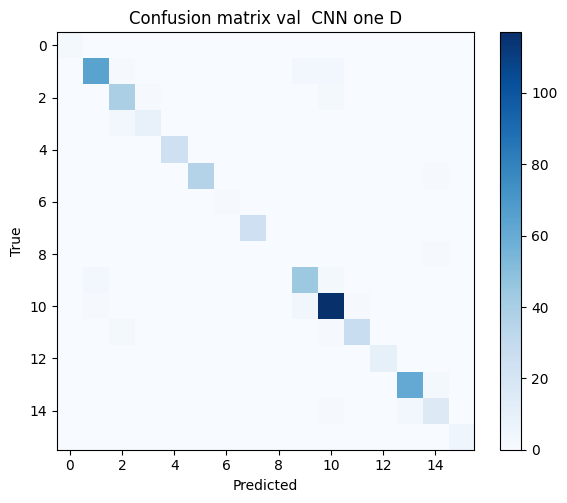

In [8]:
# This cell evaluates the best model on validation and shows a confusion matrix
model.load_state_dict(best_state)                               # load best weights
model.to(DEVICE).eval()                                         # eval mode
with torch.no_grad():
    v_logits = []
    v_targets = []
    for xb, yb in dl_val:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        v_logits.append(model(xb))
        v_targets.append(yb)
    v_logits = torch.cat(v_logits, 0)
    v_targets = torch.cat(v_targets, 0)
    vm = metrics_from_logits(v_logits, v_targets, num_classes)

print("Val accuracy", vm["acc"])
print("Val kappa", vm["kappa"])
print("Val f1 macro", vm["f1"])

plt.figure(figsize=(6, 5))
plt.imshow(vm["cm"], cmap="Blues")
plt.title("Confusion matrix val  CNN one D")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIGS / "cnn1d_confusion_val.png", dpi=150)
plt.show()


Test accuracy 0.9351219512195122
Test kappa 0.9259801621947988
Test f1 macro 0.9497170681805154


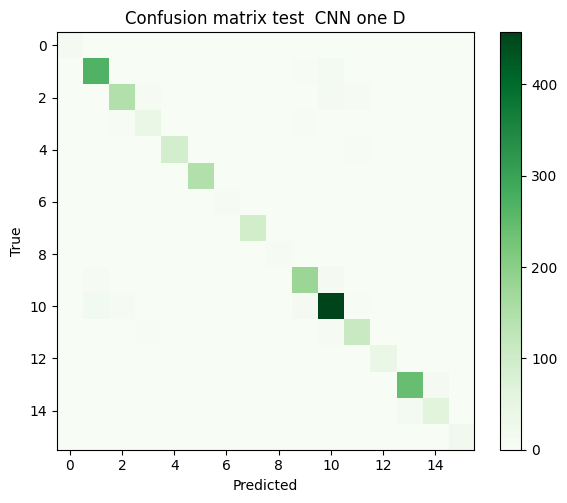


Classification report on test
              precision    recall  f1-score   support

     class_1     1.0000    1.0000    1.0000         9
     class_2     0.9150    0.9406    0.9276       286
     class_3     0.9542    0.8795    0.9154       166
     class_4     0.8542    0.8723    0.8632        47
     class_5     0.9891    0.9381    0.9630        97
     class_6     0.9732    0.9932    0.9831       146
     class_7     1.0000    1.0000    1.0000         5
     class_8     0.9796    1.0000    0.9897        96
     class_9     1.0000    1.0000    1.0000         4
    class_10     0.9175    0.9175    0.9175       194
    class_11     0.9232    0.9308    0.9270       491
    class_12     0.9256    0.9412    0.9333       119
    class_13     1.0000    1.0000    1.0000        41
    class_14     0.9528    0.9565    0.9546       253
    class_15     0.8378    0.8052    0.8212        77
    class_16     1.0000    1.0000    1.0000        19

    accuracy                         0.9351      

1082

In [9]:
# This cell runs the final test and prints the report
with torch.no_grad():
    t_logits = []
    t_targets = []
    for xb, yb in dl_test:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        t_logits.append(model(xb))
        t_targets.append(yb)
    t_logits = torch.cat(t_logits, 0)
    t_targets = torch.cat(t_targets, 0)
    tm = metrics_from_logits(t_logits, t_targets, num_classes)

print("Test accuracy", tm["acc"])
print("Test kappa", tm["kappa"])
print("Test f1 macro", tm["f1"])

plt.figure(figsize=(6, 5))
plt.imshow(tm["cm"], cmap="Greens")
plt.title("Confusion matrix test  CNN one D")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIGS / "cnn1d_confusion_test.png", dpi=150)
plt.show()

                                                                                                       # per class report
y_true_test = t_targets.cpu().numpy()
y_pred_test = t_logits.argmax(1).cpu().numpy()
names = [f"class_{i}" for i in range(1, num_classes + 1)]
print("\nClassification report on test")
print(classification_report(y_true_test, y_pred_test, target_names=names, digits=4, zero_division=0))

                                                                                                       # save reports
(Path(FIGS) / "cnn1d_classification_report_test.txt").write_text(
    classification_report(y_true_test, y_pred_test, target_names=names, digits=4, zero_division=0)
)


In [10]:
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

                                                                                   # convert tensors to numpy
y_true = t_targets.cpu().numpy()
y_pred = t_logits.argmax(1).cpu().numpy()

                                                                                   # global metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

                                                                                   # per class metrics
prec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print("Overall accuracy:", oa)
print("Cohen kappa:", kappa)
print("Macro precision:", prec_macro)
print("Macro recall:", rec_macro)
print("Macro f1:", f1_macro)
print("Weighted precision:", prec_weighted)
print("Weighted recall:", rec_weighted)
print("Weighted f1:", f1_weighted)

print("\nPer class metrics")
for i, (p, r, f1, s) in enumerate(
    zip(prec_class, rec_class, f1_class, support_class), start=1
):
    print(
        f"Class {i:02d}: "
        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"
    )

print("\nFull classification report")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],
        digits=4,
        zero_division=0,
    )
)


Overall accuracy: 0.9351219512195122
Cohen kappa: 0.9259801621947988
Macro precision: 0.9513893329685187
Macro recall: 0.9484303315920665
Macro f1: 0.9497170681805154
Weighted precision: 0.935275574760582
Weighted recall: 0.9351219512195122
Weighted f1: 0.9349845081543647

Per class metrics
Class 01: precision=1.0000, recall=1.0000, f1=1.0000, support=9
Class 02: precision=0.9150, recall=0.9406, f1=0.9276, support=286
Class 03: precision=0.9542, recall=0.8795, f1=0.9154, support=166
Class 04: precision=0.8542, recall=0.8723, f1=0.8632, support=47
Class 05: precision=0.9891, recall=0.9381, f1=0.9630, support=97
Class 06: precision=0.9732, recall=0.9932, f1=0.9831, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=0.9796, recall=1.0000, f1=0.9897, support=96
Class 09: precision=1.0000, recall=1.0000, f1=1.0000, support=4
Class 10: precision=0.9175, recall=0.9175, f1=0.9175, support=194
Class 11: precision=0.9232, recall=0.9308, f1=0.9270, sup

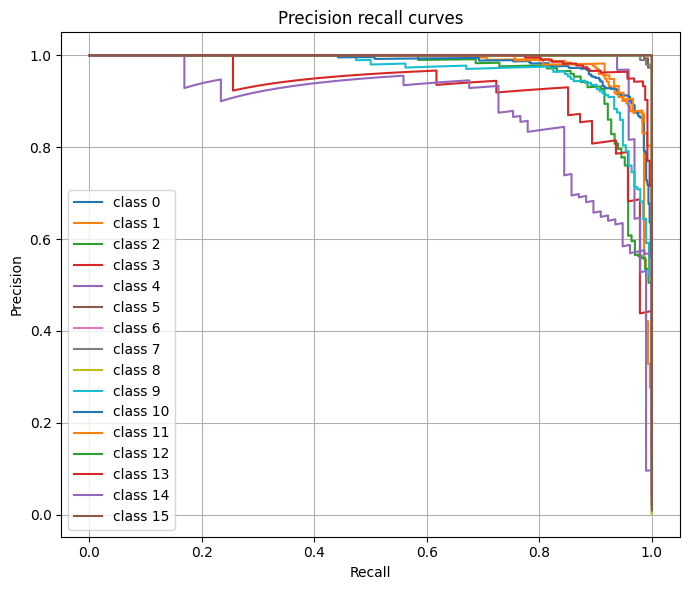

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

                                                                          # One hot for true labels
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

                                                                          # Softmax scores
probs = torch.softmax(t_logits, dim=1).cpu().numpy()

plt.figure(figsize=(7, 6))

for i in range(num_classes):
    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    plt.plot(rec, prec, label=f"class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision recall curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIGS / "precision_recall_curves.png", dpi=150)
plt.show()


In [ ]:
# CNN 1D band importance on CPU  use ds_val.y as zero based already
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

                                                                                         # rebuild a fresh CPU model and load best weights without touching the live model
ckpt_path = RUNS / "cnn1d_plain_best.pth"                                                # path to checkpoint
ckpt = torch.load(ckpt_path, map_location="cpu")                                         # load on cpu
state_dict = ckpt["state_dict"]                                                          # weights

class SpectralCNN1D(nn.Module):
    def __init__(self, in_len: int, num_classes: int, p_drop: float = 0.3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p_drop),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p_drop),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_len)
            flat = self.feat(dummy).view(1, -1).shape[1]
        self.cls = nn.Sequential(
            nn.Linear(flat, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        z = self.feat(x)
        z = z.view(z.size(0), -1)
        return self.cls(z)

model_cpu = SpectralCNN1D(in_len=B, num_classes=num_classes, p_drop=0.3)
model_cpu.load_state_dict(state_dict)
model_cpu.eval()

                                                                                         # validation arrays
Xv = ds_val.X.astype(np.float32)                                                         # N by B
Yv = ds_val.y.astype(np.int64)                                                           # already zero based  do not subtract one

                                                                                         # quick checks
assert Xv.shape[1] == B, "band count mismatch"
assert Yv.min() >= 0 and Yv.max() < num_classes, "labels out of range"
assert not np.isnan(Xv).any() and not np.isinf(Xv).any(), "NaN or Inf found"

                                                                                         # gradient scores
crit = nn.CrossEntropyLoss()
BATCH = 256
grad_sum = np.zeros(B, dtype=np.float64)
count_sum = 0
s = 0
while s < Xv.shape[0]:
    e = min(Xv.shape[0], s + BATCH)
    xb = torch.from_numpy(Xv[s:e]).unsqueeze(1).requires_grad_(True)                     # N by 1 by B
    yb = torch.from_numpy(Yv[s:e])
    logits = model_cpu(xb)
    loss = crit(logits, yb)
    model_cpu.zero_grad(set_to_none=True)
    if xb.grad is not None:
        xb.grad.zero_()
    loss.backward()
    g = xb.grad.abs().detach().numpy().squeeze(1)                                        # N by B
    grad_sum += g.sum(axis=0)
    count_sum += g.shape[0]
    s = e

scores = grad_sum / max(1, count_sum)                                                    # mean abs grad per band
order = np.argsort(-scores)
top_k = min(25, B)

print("Top bands by gradient sensitivity on CPU")
for i in range(top_k):
    b = int(order[i])
    print(f"Rank {i+1:02d}  band {b:03d}  score {scores[b]:.6f}")

plt.figure(figsize=(10, 4))
plt.bar(np.arange(top_k), scores[order[:top_k]])
plt.xticks(np.arange(top_k), [str(int(b)) for b in order[:top_k]])
plt.xlabel("Band index")
plt.ylabel("Average absolute input gradient")
plt.title("Band importance  CNN 1D  validation  CPU")
plt.tight_layout()
plt.savefig(FIGS / "cnn1d_band_importance_gradient_cpu_fixed.png", dpi=150)
plt.show()

                                                                                         # save full table
out_csv = FIGS / "cnn1d_band_importance_gradient_cpu_full.csv"
pd.DataFrame({"band": np.arange(B), "grad_score": scores}).to_csv(out_csv, index=False)
print("Saved table at", out_csv.as_posix())



In [ ]:
# This cell builds combined arrays for train plus val for cross validation
X_tv = np.concatenate([ds_train.X, ds_val.X], axis=0).astype(np.float32)    # features N by B
y_tv = np.concatenate([ds_train.y, ds_val.y], axis=0).astype(np.int64) - 1  # zero based labels
print("TV set", X_tv.shape, "labels", y_tv.shape)


In [ ]:
# This cell defines a function that trains one fold and returns val metrics
def train_one_fold_cnn1d(X_tr, y_tr, X_va, y_va, in_len, num_classes, device):
    model_f = SpectralCNN1D(in_len=in_len, num_classes=num_classes, p_drop=0.3).to(device)
    crit_f = nn.CrossEntropyLoss()
    opt_f = optim.Adam(model_f.parameters(), lr=1e-3, weight_decay=1e-5)
    sch_f = optim.lr_scheduler.ReduceLROnPlateau(opt_f, mode="min", factor=0.5, patience=3, verbose=False)

    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr).unsqueeze(1), torch.from_numpy(y_tr)), batch_size=256, shuffle=True)
    dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va).unsqueeze(1), torch.from_numpy(y_va)), batch_size=256, shuffle=False)

    best_loss = float("inf")
    best_state = None
    bad = 0
    for ep in range(1, 101):
        model_f.train()
        run = 0.0
        n = 0
        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device)
            opt_f.zero_grad(set_to_none=True)
            lg = model_f(xb)
            ls = crit_f(lg, yb)
            ls.backward()
            opt_f.step()
            run += ls.item() * xb.size(0)
            n += xb.size(0)
        tr_loss = run / max(1, n)

        model_f.eval()
        with torch.no_grad():
            v_sum = 0.0
            m = 0
            logits_list = []
            targets_list = []
            for xb, yb in dl_va:
                xb = xb.to(device)
                yb = yb.to(device)
                lg = model_f(xb)
                ls = crit_f(lg, yb)
                v_sum += ls.item() * xb.size(0)
                m += xb.size(0)
                logits_list.append(lg)
                targets_list.append(yb)
            v_loss = v_sum / max(1, m)
            logits = torch.cat(logits_list, 0)
            tgts = torch.cat(targets_list, 0)
            preds = logits.argmax(1).cpu().numpy()
            true = tgts.cpu().numpy()
            acc = accuracy_score(true, preds)
            prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(num_classes), average="macro", zero_division=0)
            kap = cohen_kappa_score(true, preds)
        sch_f.step(v_loss)

        if v_loss < best_loss:
            best_loss = v_loss
            best_state = {k: v.cpu().clone() for k, v in model_f.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= 10:
                break

    model_f.load_state_dict(best_state)
    model_f.eval()
    with torch.no_grad():
        logits_list = []
        targets_list = []
        for xb, yb in dl_va:
            xb = xb.to(device)
            yb = yb.to(device)
            logits_list.append(model_f(xb))
            targets_list.append(yb)
        logits = torch.cat(logits_list, 0)
        tgts = torch.cat(targets_list, 0)
        preds = logits.argmax(1).cpu().numpy()
        true = tgts.cpu().numpy()
        acc = accuracy_score(true, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(num_classes), average="macro", zero_division=0)
        kap = cohen_kappa_score(true, preds)
    return acc, f1, kap


In [ ]:
# This cell prints a short summary to paste into the results
print("Model  CNN one D spectral")                                                                # model name
print("Params", sum(p.numel() for p in model.parameters()))                                       # parameter count
print("Val  acc", round(vm["acc"], 4), "kappa", round(vm["kappa"], 4), "f1", round(vm["f1"], 4))  # val
print("Test acc", round(tm["acc"], 4), "kappa", round(tm["kappa"], 4), "f1", round(tm["f1"], 4))  # test
print("Runs", RUNS.as_posix(), "Figs", FIGS.as_posix())                                           # paths

In [ ]:
# Force torch to think CUDA is unavailable so optimizers never touch CUDA paths
import torch, types
torch.backends.cudnn.enabled = False                               # turn off cudnn
torch.cuda.is_available = lambda : False                           # patch to always return False
print("CUDA available seen by torch:", torch.cuda.is_available())


In [ ]:
# Rebuild arrays and pick class count from the data you will use
import numpy as np

X_tv = np.concatenate([ds_train.X, ds_val.X], axis=0).astype(np.float32)                # features
y_tv = np.concatenate([ds_train.y, ds_val.y], axis=0).astype(np.int64)                  # zero based labels

C_tv = int(y_tv.max()) + 1                                                              # classes seen in train plus val

print("X_tv", X_tv.shape, "y_tv", y_tv.shape, "C_tv", C_tv)
assert y_tv.min() >= 0 and y_tv.max() < C_tv, "labels out of range"
assert not np.isnan(X_tv).any() and not np.isinf(X_tv).any(), "NaN or Inf in features"


In [ ]:
# Five fold cross validation for CNN 1D on CPU only
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score
import numpy as np

CV_DEVICE = torch.device("cpu")                                                                                             # force cpu

class SpectralCNN1D(nn.Module):
    def __init__(self, in_len: int, num_classes: int, p_drop: float = 0.3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p_drop),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p_drop),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_len)
            flat = self.feat(dummy).view(1, -1).shape[1]
        self.cls = nn.Sequential(
            nn.Linear(flat, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        z = self.feat(x)
        z = z.view(z.size(0), -1)
        return self.cls(z)

def train_one_fold_cpu(X_tr, y_tr, X_va, y_va, in_len, C):
    model_f = SpectralCNN1D(in_len=in_len, num_classes=C, p_drop=0.3).to(CV_DEVICE)
    crit_f = nn.CrossEntropyLoss()
    opt_f = optim.Adam(model_f.parameters(), lr=1e-3, weight_decay=1e-4)
    sch_f = optim.lr_scheduler.ReduceLROnPlateau(opt_f, mode="min", factor=0.5, patience=3)

    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr).unsqueeze(1), torch.from_numpy(y_tr)),
                       batch_size=256, shuffle=True, num_workers=0, pin_memory=False)
    dl_va = DataLoader(TensorDataset(torch.from_numpy(X_va).unsqueeze(1), torch.from_numpy(y_va)),
                       batch_size=256, shuffle=False, num_workers=0, pin_memory=False)

    best_loss, best_state, bad = float("inf"), None, 0
    for ep in range(1, 101):
        model_f.train()
        run, n = 0.0, 0
        for xb, yb in dl_tr:
            xb = xb.to(CV_DEVICE); yb = yb.to(CV_DEVICE)
            opt_f.zero_grad(set_to_none=True)
            lg = model_f(xb)
            ls = crit_f(lg, yb)
            ls.backward()
            opt_f.step()
            run += ls.item() * xb.size(0); n += xb.size(0)
        tr_loss = run / max(1, n)

        model_f.eval()
        with torch.no_grad():
            v_sum, m = 0.0, 0
            logits_list, targets_list = [], []
            for xb, yb in dl_va:
                lg = model_f(xb.to(CV_DEVICE))
                ls = crit_f(lg, yb.to(CV_DEVICE))
                v_sum += ls.item() * xb.size(0); m += xb.size(0)
                logits_list.append(lg); targets_list.append(yb.to(CV_DEVICE))
            v_loss = v_sum / max(1, m)
        sch_f.step(v_loss)

        if v_loss < best_loss:
            best_loss = v_loss
            best_state = {k: v.cpu().clone() for k, v in model_f.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= 10:
                break

    model_f.load_state_dict(best_state)
    model_f.eval()
    with torch.no_grad():
        logits_list, targets_list = [], []
        for xb, yb in dl_va:
            logits_list.append(model_f(xb.to(CV_DEVICE)))
            targets_list.append(yb.to(CV_DEVICE))
        logits = torch.cat(logits_list, 0)
        tgts = torch.cat(targets_list, 0)
    preds = logits.argmax(1).cpu().numpy()
    true = tgts.cpu().numpy()
    acc = accuracy_score(true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)
    kap = cohen_kappa_score(true, preds)
    return acc, f1, kap

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s, kaps = [], [], []
for fold, (idx_tr, idx_va) in enumerate(skf.split(X_tv, y_tv), 1):
    X_tr, y_tr = X_tv[idx_tr], y_tv[idx_tr]
    X_va, y_va = X_tv[idx_va], y_tv[idx_va]
    acc, f1, kap = train_one_fold_cpu(X_tr, y_tr, X_va, y_va, in_len=B, C=C_tv)
    print(f"Fold {fold}  acc {acc:.4f}  f1 {f1:.4f}  kappa {kap:.4f}")
    accs.append(acc); f1s.append(f1); kaps.append(kap)

print("\nCV mean acc", np.mean(accs).round(4), "std", np.std(accs).round(4))
print("CV mean f1", np.mean(f1s).round(4), "std", np.std(f1s).round(4))
print("CV mean kappa", np.mean(kaps).round(4), "std", np.std(kaps).round(4))


In [ ]:
# Define build_cnn1d, metrics_from_logits, and train_eval_config if they are missing
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score

# sanity checks for globals
assert "ds_train" in globals() and "ds_val" in globals(), "Make ds_train and ds_val first"
assert "B" in globals() and "num_classes" in globals(), "Set B and num_classes first"
assert "DEVICE" in globals(), "Set DEVICE first"

# model builder
try:
    build_cnn1d
except NameError:
    def build_cnn1d(in_len, num_classes, c1=32, c2=64, c3=128, k1=7, k2=5, k3=3, p_drop=0.3):
        class SpectralCNN1D(nn.Module):
            def __init__(self, in_len, num_classes, c1, c2, c3, k1, k2, k3, p_drop):
                super().__init__()
                pad1, pad2, pad3 = k1 // 2, k2 // 2, k3 // 2
                self.feat = nn.Sequential(
                    nn.Conv1d(1, c1, kernel_size=k1, padding=pad1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c1),
                    nn.Conv1d(c1, c2, kernel_size=k2, padding=pad2),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c2),
                    nn.MaxPool1d(kernel_size=2),
                    nn.Dropout(p_drop),
                    nn.Conv1d(c2, c3, kernel_size=k3, padding=pad3),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c3),
                    nn.MaxPool1d(kernel_size=2),
                    nn.Dropout(p_drop),
                )
                with torch.no_grad():
                    dummy = torch.zeros(1, 1, in_len)
                    flat = self.feat(dummy).view(1, -1).shape[1]
                self.cls = nn.Sequential(
                    nn.Linear(flat, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p_drop),
                    nn.Linear(256, num_classes),
                )
            def forward(self, x):
                z = self.feat(x)
                z = z.view(z.size(0), -1)
                return self.cls(z)
        return SpectralCNN1D(in_len, num_classes, c1, c2, c3, k1, k2, k3, p_drop)

# metrics helper
try:
    metrics_from_logits
except NameError:
    def metrics_from_logits(logits, targets, C):
        preds = logits.argmax(1).cpu().numpy()
        true = targets.cpu().numpy()
        acc = accuracy_score(true, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)
        kap = cohen_kappa_score(true, preds)
        return {"acc": acc, "f1": f1, "kappa": kap}

# train and eval one config
try:
    train_eval_config
except NameError:
    def train_eval_config(cfg, device=DEVICE, epochs=60, patience=8):
        bs = int(cfg["batch"])
        lr = float(cfg["lr"])
        wd = float(cfg["wd"])
        p_drop = float(cfg["p_drop"])
        c1, c2, c3 = int(cfg["c1"]), int(cfg["c2"]), int(cfg["c3"])
        k1, k2, k3 = int(cfg["k1"]), int(cfg["k2"]), int(cfg["k3"])

        dl_tr = DataLoader(ds_train, batch_size=bs, shuffle=True, drop_last=False)
        dl_va = DataLoader(ds_val, batch_size=bs, shuffle=False, drop_last=False)

        model = build_cnn1d(B, num_classes, c1, c2, c3, k1, k2, k3, p_drop).to(device)
        crit = nn.CrossEntropyLoss()
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

        best_loss = float("inf")
        best_state = None
        best_ep = 0
        bad = 0
        t0 = time.time()

        for ep in range(1, epochs + 1):
            model.train()
            run, n = 0.0, 0
            for xb, yb in dl_tr:
                xb = xb.to(device); yb = yb.to(device)
                opt.zero_grad(set_to_none=True)
                lg = model(xb)
                ls = crit(lg, yb)
                ls.backward()
                opt.step()
                run += ls.item() * xb.size(0); n += xb.size(0)
            tr_loss = run / max(1, n)

            model.eval()
            with torch.no_grad():
                v_sum, m = 0.0, 0
                all_lg, all_y = [], []
                for xb, yb in dl_va:
                    xb = xb.to(device); yb = yb.to(device)
                    lg = model(xb)
                    ls = crit(lg, yb)
                    v_sum += ls.item() * xb.size(0); m += xb.size(0)
                    all_lg.append(lg); all_y.append(yb)
                va_loss = v_sum / max(1, m)
                lg_cat = torch.cat(all_lg, 0); y_cat = torch.cat(all_y, 0)
                va_m = metrics_from_logits(lg_cat, y_cat, num_classes)

            sch.step(va_loss)

            if va_loss < best_loss:
                best_loss = va_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                best_ep = ep
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    break

        secs = time.time() - t0
        params = int(sum(p.numel() for p in model.parameters()))
        out = dict(cfg)
        out.update({
            "val_loss": float(best_loss),
            "val_acc": float(va_m["acc"]),
            "val_f1": float(va_m["f1"]),
            "val_kappa": float(va_m["kappa"]),
            "best_epoch": int(best_ep),
            "params": params,
            "train_time_sec": float(round(secs, 2)),
        })
        return out, best_state

print("Functions ready  build_cnn1d, metrics_from_logits, train_eval_config")


In [ ]:
# Cell 0  setup for search  imports device and missing globals

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score

# pick device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# if build_cnn1d is not defined yet bring it here
try:
    build_cnn1d
except NameError:
    def build_cnn1d(in_len, num_classes, c1=32, c2=64, c3=128, k1=7, k2=5, k3=3, p_drop=0.3):
        class SpectralCNN1D(nn.Module):
            def __init__(self, in_len, num_classes, c1, c2, c3, k1, k2, k3, p_drop):
                super().__init__()
                pad1, pad2, pad3 = k1 // 2, k2 // 2, k3 // 2
                self.feat = nn.Sequential(
                    nn.Conv1d(1, c1, kernel_size=k1, padding=pad1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c1),
                    nn.Conv1d(c1, c2, kernel_size=k2, padding=pad2),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c2),
                    nn.MaxPool1d(kernel_size=2),
                    nn.Dropout(p_drop),
                    nn.Conv1d(c2, c3, kernel_size=k3, padding=pad3),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(c3),
                    nn.MaxPool1d(kernel_size=2),
                    nn.Dropout(p_drop),
                )
                with torch.no_grad():
                    dummy = torch.zeros(1, 1, in_len)
                    flat = self.feat(dummy).view(1, -1).shape[1]
                self.cls = nn.Sequential(
                    nn.Linear(flat, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p_drop),
                    nn.Linear(256, num_classes),
                )
            def forward(self, x):
                z = self.feat(x)
                z = z.view(z.size(0), -1)
                return self.cls(z)
        return SpectralCNN1D(in_len, num_classes, c1, c2, c3, k1, k2, k3, p_drop)

# make sure ds_train ds_val exist and set B and num_classes from them if missing
try:
    B
except NameError:
    try:
        B = int(ds_train.X.shape[1])
        print("Inferred B from ds_train:", B)
    except Exception as e:
        raise RuntimeError("B is not defined. Create ds_train first.") from e

try:
    num_classes
except NameError:
    try:
        num_classes = int(max(ds_train.y.max(), ds_val.y.max())) + 1
        print("Inferred num_classes from datasets:", num_classes)
    except Exception as e:
        raise RuntimeError("num_classes is not defined. Build ds_train and ds_val first.") from e


In [ ]:
# Random search over a modest space, keep top results
import random
random.seed(42)

def sample_config():
    return {
        "batch": random.choice([128, 192, 256, 320]),
        "lr": 10 ** random.uniform(-4.5, -2.5),
        "wd": 10 ** random.uniform(-6.0, -3.5),
        "p_drop": random.choice([0.1, 0.2, 0.3, 0.4]),
        "c1": random.choice([32, 48, 64]),
        "c2": random.choice([64, 96, 128]),
        "c3": random.choice([96, 128, 160]),
        "k1": random.choice([3, 5, 7, 9]),
        "k2": random.choice([3, 5, 7]),
        "k3": random.choice([3, 5]),
    }

N_TRIALS = 20                                                                  # you can raise this if you have time
rand_rows = []
best_snapshots = {}                                                            # keep best state dict per trial id if you ever want to reuse

for t in range(1, N_TRIALS + 1):
    cfg = sample_config()
    res, state = train_eval_config(cfg, device=DEVICE, epochs=50, patience=8)
    res["trial"] = t
    rand_rows.append(res)
    best_snapshots[t] = state
    print(f"trial {t:02d}  val_f1 {res['val_f1']:.4f}  val_acc {res['val_acc']:.4f}  lr {res['lr']:.5f}  wd {res['wd']:.1e}")

df_rand = pd.DataFrame(rand_rows).sort_values("val_f1", ascending=False).reset_index(drop=True)
display(df_rand.head(10))

rand_csv = RUNS / "cnn1d_random_search.csv"
df_rand.to_csv(rand_csv, index=False)
print("Saved random search table to", rand_csv.as_posix())

best_cfg = df_rand.iloc[0].to_dict()
print("Best from random search:", {k: best_cfg[k] for k in ["batch","lr","wd","p_drop","c1","c2","c3","k1","k2","k3"]})


In [ ]:
# Build a small grid around the best config and search it

def around(value, mults=(0.5, 1.0, 2.0), clip=None):
    xs = [value * m for m in mults]
    if clip is not None:
        xs = [max(clip[0], min(clip[1], v)) for v in xs]
    return sorted(set(xs))

b0 = int(best_cfg["batch"])
lr0 = float(best_cfg["lr"])
wd0 = float(best_cfg["wd"])
p0 = float(best_cfg["p_drop"])
c1_0, c2_0, c3_0 = int(best_cfg["c1"]), int(best_cfg["c2"]), int(best_cfg["c3"])
k1_0, k2_0, k3_0 = int(best_cfg["k1"]), int(best_cfg["k2"]), int(best_cfg["k3"])

grid = {
    "batch": sorted(set([max(64, int(b0*0.75)), b0, min(512, int(b0*1.25))])),
    "lr": [lr0/2, lr0, lr0*2],
    "wd": [wd0/3, wd0, wd0*3],
    "p_drop": sorted(set([max(0.05, round(p0-0.1,2)), p0, min(0.5, round(p0+0.1,2))])),
    "c1": sorted(set([max(16, c1_0-16), c1_0, min(96, c1_0+16)])),
    "c2": sorted(set([max(32, c2_0-32), c2_0, min(160, c2_0+32)])),
    "c3": sorted(set([max(64, c3_0-32), c3_0, min(192, c3_0+32)])),
    "k1": sorted(set([max(3, k1_0-2), k1_0, min(11, k1_0+2)])),
    "k2": sorted(set([max(3, k2_0-2), k2_0, min(9, k2_0+2)])),
    "k3": sorted(set([max(3, k3_0-2), k3_0])),
}

# build full list but cap total to keep runtime sane
from itertools import product

keys = list(grid.keys())
vals = [grid[k] for k in keys]
cands = list(product(*vals))
print("Grid size candidate count:", len(cands))

# if it is too big, sample a subset
MAX_GRID = 40
if len(cands) > MAX_GRID:
    idx = np.linspace(0, len(cands) - 1, num=MAX_GRID, dtype=int)
    cands = [cands[i] for i in idx]
    print("Subsampled grid to", len(cands))

grid_rows = []
for i, tup in enumerate(cands, 1):
    cfg = {k: v for k, v in zip(keys, tup)}
    res, _ = train_eval_config(cfg, device=DEVICE, epochs=50, patience=8)
    res["grid_id"] = i
    grid_rows.append(res)
    print(f"grid {i:02d}  val_f1 {res['val_f1']:.4f}  val_acc {res['val_acc']:.4f}")

df_grid = pd.DataFrame(grid_rows).sort_values("val_f1", ascending=False).reset_index(drop=True)
display(df_grid.head(10))

grid_csv = RUNS / "cnn1d_grid_search.csv"
df_grid.to_csv(grid_csv, index=False)
print("Saved grid search table to", grid_csv.as_posix())

best_final = df_grid.iloc[0].to_dict()
print("Best from grid:", {k: best_final[k] for k in ["batch","lr","wd","p_drop","c1","c2","c3","k1","k2","k3"]})


In [ ]:
# RS3  grid search around the random best

def around(value, mults=(0.5, 1.0, 2.0), clip=None):
    xs = [value * m for m in mults]
    if clip is not None:
        xs = [max(clip[0], min(clip[1], v)) for v in xs]
    return sorted(set(xs))

b0 = int(best_cfg["batch"])
lr0 = float(best_cfg["lr"])
wd0 = float(best_cfg["wd"])
p0 = float(best_cfg["p_drop"])
c1_0, c2_0, c3_0 = int(best_cfg["c1"]), int(best_cfg["c2"]), int(best_cfg["c3"])
k1_0, k2_0, k3_0 = int(best_cfg["k1"]), int(best_cfg["k2"]), int(best_cfg["k3"])

grid = {
    "batch": sorted(set([max(64, int(b0 * 0.75)), b0, min(512, int(b0 * 1.25))])),
    "lr": [lr0 / 2, lr0, lr0 * 2],
    "wd": [wd0 / 3, wd0, wd0 * 3],
    "p_drop": sorted(set([max(0.05, round(p0 - 0.1, 2)), p0, min(0.5, round(p0 + 0.1, 2))])),
    "c1": sorted(set([max(16, c1_0 - 16), c1_0, min(96, c1_0 + 16)])),
    "c2": sorted(set([max(32, c2_0 - 32), c2_0, min(160, c2_0 + 32)])),
    "c3": sorted(set([max(64, c3_0 - 32), c3_0, min(192, c3_0 + 32)])),
    "k1": sorted(set([max(3, k1_0 - 2), k1_0, min(11, k1_0 + 2)])),
    "k2": sorted(set([max(3, k2_0 - 2), k2_0, min(9, k2_0 + 2)])),
    "k3": sorted(set([max(3, k3_0 - 2), k3_0])),
}

from itertools import product
keys = list(grid.keys())
vals = [grid[k] for k in keys]
cands = list(product(*vals))
print("Grid size candidate count:", len(cands))

MAX_GRID = 40
if len(cands) > MAX_GRID:
    idx = np.linspace(0, len(cands) - 1, num=MAX_GRID, dtype=int)
    cands = [cands[i] for i in idx]
    print("Subsampled grid to", len(cands))

grid_rows = []
for i, tup in enumerate(cands, 1):
    cfg = {k: v for k, v in zip(keys, tup)}
    res, _ = train_eval_config(cfg, device=DEVICE, epochs=50, patience=8)
    res["grid_id"] = i
    grid_rows.append(res)
    print(f"grid {i:02d}  val_f1 {res['val_f1']:.4f}  val_acc {res['val_acc']:.4f}")

df_grid = pd.DataFrame(grid_rows).sort_values("val_f1", ascending=False).reset_index(drop=True)
display(df_grid.head(10))

grid_csv = RUNS / "cnn1d_grid_search.csv"
df_grid.to_csv(grid_csv, index=False)
print("Saved grid search table to", grid_csv.as_posix())

best_final = df_grid.iloc[0].to_dict()
print("Best from grid:", {k: best_final[k] for k in ["batch","lr","wd","p_drop","c1","c2","c3","k1","k2","k3"]})
